1) Description

I analyse two tables from a UBC Minecraft research server: players.csv (196 observations, 7 variables) contains one row per participant, while sessions.csv (1,535 observations, 5 variables) contains one row per gameplay session. players.csv records who each player is and whether they opted into the newsletter; sessions.csv records when each session started and ended. At a glance, a few practical issues are worth noting: some time stamps may not parse cleanly; a number of players appear in players.csv but never show up in the sessions table; some fields can be missing or inconsistently filled; time zones and daylight-saving changes could shift the recorded times; and because participation is voluntary, the data may not represent all players equally. The data were gathered in two parts: a sign-up form (player info and newsletter opt-in) and server logs (session start/end times), joined by the hashed email. We summarize the full dataset here even if we later use only a subset of variables for modeling.



**Vaiable Summary**

**players.csv**  
- `experience` · categorical 
- `subscribe`  · boolean     
- `hashedEmail`· string(key)
- `played_hours`· numeric    
- `name`       · string     
- `gender`     · categorical
- `Age`        · numeric    

**sessions.csv**  
- `hashedEmail` · string(fk) ·  players  
- `start_time` / `end_time` · string · `dd/mm/yyyy HH:MM`   
- `original_start_time` / `original_end_time` · numeric · epoch

2) Questions

Broad question:
Which player characteristics and early behaviours are most predictive of subscribing to the game-related newsletter?

Specific question:
Can players’ behaviour ( e.g. total playtime, experience level, age) help predict whether they subscribe?

The players.csv file includes each player’s unique ID and attributes such as age, country, and whether they subscribed, which serves as the response variable in my analysis. The sessions.csv file contains information on each play session, including the player ID, session duration, and other activity details that reflect player engagement. 
To prepare the data for analysis, I will join these two datasets to connect player characteristics with their gameplay behaviour. I will then summarize the session data by player to compute aggregate behavioural metrics, such as the total number of sessions, average session length, and total playtime. These summary variables will capture each player’s overall activity level and engagement.

(3) Exploratory Data Analysis and Visualization

In [15]:
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)

In [16]:
players<-read_csv("https://raw.githubusercontent.com/sylverus19-cloud/individualplanning/refs/heads/main/players.csv")
sessions<-read_csv("https://raw.githubusercontent.com/sylverus19-cloud/individualplanning/refs/heads/main/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [17]:
sessions <- sessions |>
  mutate(session_length = as.numeric(difftime(end_time, start_time, units = "hours")))
player_summary <- sessions |>
  group_by(hashedEmail) |>
  summarize(
    total_sessions = n(),
    avg_session_length = mean(session_length, na.rm = TRUE),
    total_play_time = sum(session_length, na.rm = TRUE)
  )
player_data <- players |>
  left_join(player_summary, by = "hashedEmail")

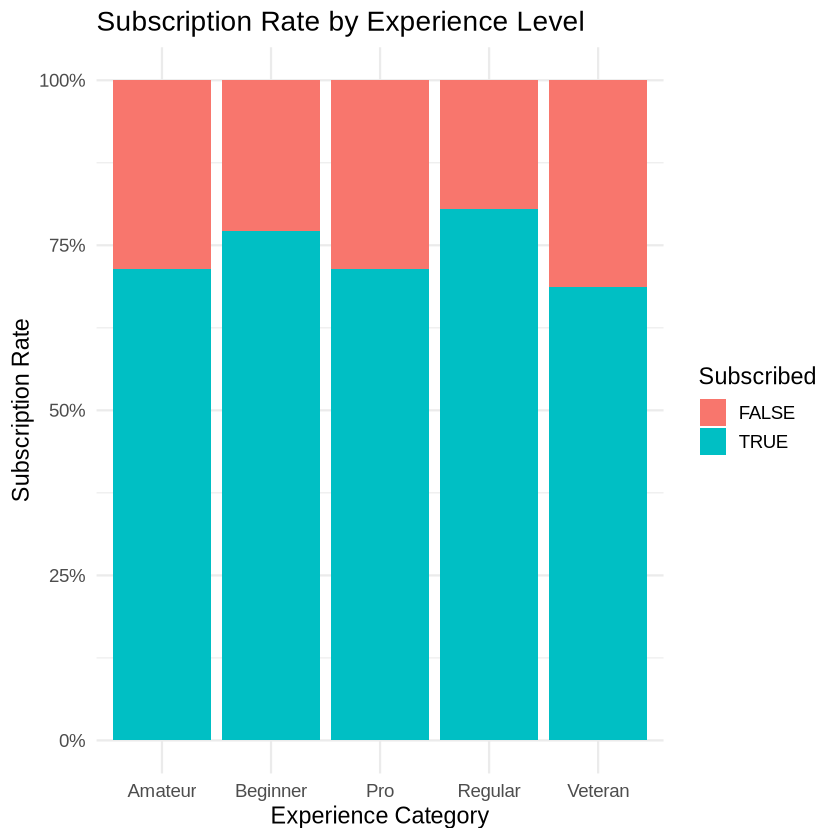

In [18]:
players_clean <- players |> filter(!is.na(subscribe))

p_experience <- players_clean |>
  ggplot(aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  labs(title = "Subscription Rate by Experience Level",
       x = "Experience Category", y = "Subscription Rate",
       fill = "Subscribed") +
  theme_minimal(base_size = 14)
p_experience

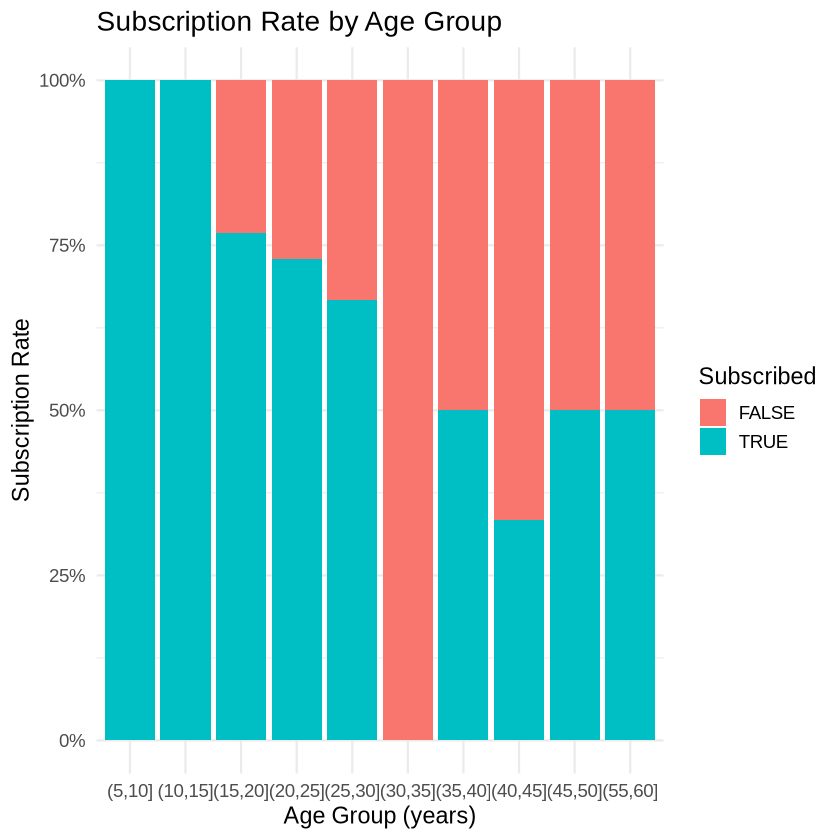

In [19]:
p_age <- players_clean |>
  filter(!is.na(Age)) |>
  mutate(age_group = cut(Age, breaks = seq(5, 60, by = 5), right = TRUE)) |>
  ggplot(aes(x = age_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = percent) +
  labs(title = "Subscription Rate by Age Group",
       x = "Age Group (years)", y = "Subscription Rate",
       fill = "Subscribed") +
  theme_minimal(base_size = 14)
p_age

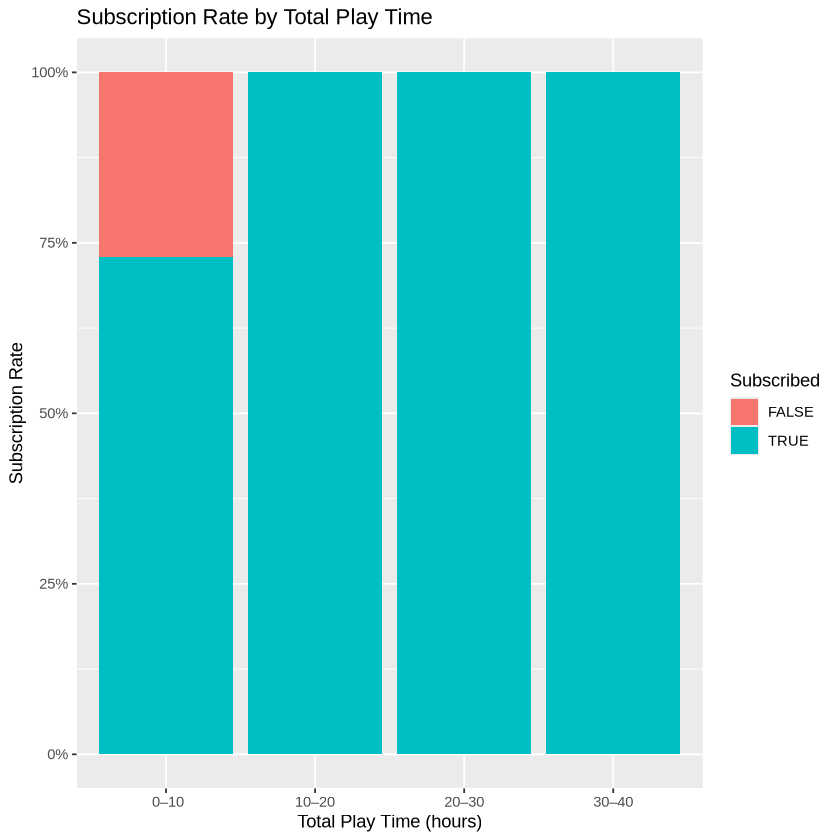

In [25]:
player_data_clean <- player_data |>
  filter(!is.na(subscribe), !is.na(total_play_time), total_play_time >= 0) |>
  mutate(total_play_time = total_play_time / 3600) 

max_time <- player_data_clean |>
  summarise(max_val = max(total_play_time, na.rm = TRUE)) |>
  pull(max_val)

p_playtime <- player_data_clean |>
  mutate(
    playtime_group = cut(
      total_play_time,
      breaks = c(seq(0, 90, by = 10), max_time), 
      include.lowest = TRUE,
      labels = paste0(
        format(seq(0, 90, by = 10)), "–",
        c(format(seq(10, 90, by = 10)), paste0(round(max_time, 1), "+"))))) |>
  ggplot(aes(x = playtime_group, fill = subscribe)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent) +
  labs(
    title = "Subscription Rate by Total Play Time",
    x = "Total Play Time (hours)",
    y = "Subscription Rate",
    fill = "Subscribed") 

p_playtime


In [ ]:
players_means <- players |>
  select(where(is.numeric)) |>
  summarise(across(everything(), mean, na.rm = TRUE))

players_means

The plots show that players with more experience and longer playtime are more likely to subscribe to the newsletter. Beginners and players with low total playtime have a smaller proportion of subscribers.
For age, younger players (under 25) have higher subscription rates, while older players tend to subscribe less often.
Overall, these results suggest that engagement and experience are stronger predictors of subscription than age.

4) 